In [1]:
from copy import deepcopy
from pathlib import Path
import pickle
import json
from typing import Literal

from gears import PertData
import seaborn as sns
from sklearn.linear_model import ElasticNet
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/home/users/geroldcsendes/miniconda3/envs/scgpt_yml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


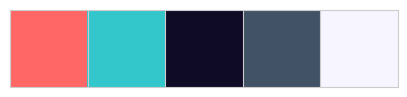

In [2]:
sns.set_style("whitegrid")
colors = ['#FF6666', '#33C7CC', '#0F0A26', '#425266', '#F7F5FF']
sns.set_palette(sns.color_palette(colors))
sns.palplot(sns.color_palette(colors))

In [3]:
def _filt_self_from_de(pert_data, is_norman: bool):

    DE_COL = "rank_genes_groups_cov_all"  # top_non_dropout_de_20

    gene_name_to_ensg = dict(zip(pert_data.adata.var["gene_name"], pert_data.adata.var.index))
    rank_genes_groups_cov_all = deepcopy(pert_data.adata.uns[DE_COL])

    updated_rank_genes_groups_cov_all = {}

    for k, v in rank_genes_groups_cov_all.items():
        condition = k.split("_")[1]
        condition_gene_name = condition.replace("ctrl+", "").replace("+ctrl", "")

        if is_norman:
            condition_ensg_name = gene_name_to_ensg.get(condition_gene_name, None)
            updated_rank_genes_groups_cov_all[k] = v[v != condition_ensg_name]
        else:
            if "+" in condition_gene_name:
                condition_gene_name = condition_gene_name.split("+")
                assert len(condition_gene_name) == 2
                condition_ensg_name = [gene_name_to_ensg.get(g, None) for g in condition_gene_name]
                mask = ~np.isin(v, condition_ensg_name)
                updated_rank_genes_groups_cov_all[k] = v[mask]
            else:
                condition_ensg_name = gene_name_to_ensg.get(condition_gene_name, None)
                updated_rank_genes_groups_cov_all[k] = v[v != condition_ensg_name]
    
    return updated_rank_genes_groups_cov_all


def eval(pred: np.ndarray, data: dict, pert_data: PertData, is_norman: bool, key_pattern: str):

    DE_COL = "rank_genes_groups_cov_all"  # top_non_dropout_de_20
    de_dict =  pert_data.adata.uns[DE_COL]
    de_dict_noself = _filt_self_from_de(pert_data, is_norman)

    ctrl = data['ctrl_mean']
    assert pred.shape[1] == ctrl.shape[0]

    cols = data['test_y'].columns

    pearson_raw = []
    pearson_delta = []
    pearson_delta_de = []
    pearson_delta_de_no_knockout = []

    for i in range(pred.shape[0]):
        _pred = pred[i]
        _target_df = data['test_y'].iloc[i]
        _target = data['test_y'].iloc[i].values

        pearson_raw.append(pearsonr(_pred, _target)[0])
        pearson_delta.append(pearsonr(_pred - ctrl, _target - ctrl)[0])

        de = de_dict[key_pattern % _target_df.name][:20]
        de_pred_indices = np.array([idx for idx, i in enumerate(cols) if i in de])

        de_no_self = de_dict_noself[key_pattern % _target_df.name][:20]
        de_no_self_pred_indices = [idx for idx, i in enumerate(cols) if i in de_no_self]

        pearson_delta_de.append(
            pearsonr((_pred - ctrl)[de_pred_indices], (_target - ctrl)[de_pred_indices])[0]
        )
        pearson_delta_de_no_knockout.append(
            pearsonr((_pred - ctrl)[de_no_self_pred_indices], (_target - ctrl)[de_no_self_pred_indices])[0]
        )

    return dict(
        pearson=np.mean(pearson_raw),
        pearson_delta=np.mean(pearson_delta),
        pearson_de_delta=np.mean(pearson_delta_de),
        pearson_delta_de_no_knockout=np.mean(pearson_delta_de_no_knockout))

In [4]:
def _get_go_features(is_norman: bool, perturbation_list: list, go_pca: pd.DataFrame):

    GO_NULL_STR = "NULL"
    go_pca = go_pca.copy()
    pert_list = [i.replace("ctrl+", "").replace("+ctrl", "") for i in perturbation_list]
    if is_norman:
        # insert NULL as a row to the go_pca with 0 values
        go_pca.loc[GO_NULL_STR] = 0

        pert1 = []
        pert2 = []
        for i in pert_list:
            if '+' in i:
                p1, p2 = i.split('+')
                pert1.append(p1)
                pert2.append(p2)
            else:
                pert1.append(i)
                pert2.append('NULL')
        
        go_features = go_pca.loc[pert1].values - go_pca.loc[pert2].values

    else:
        go_features = go_pca.loc[pert_list]
    return go_features

def create_bulk_data(pert_data, go_pca_, is_norman: bool):

    data_splits = deepcopy(pert_data.set2conditions)

    train_samples = data_splits['train'] + data_splits['val']
    train_samples.remove('ctrl')
    test_samples = data_splits['test']

    assert 'ctrl' not in test_samples, "ctrl in test samples"

    data = pert_data.adata.to_df()
    data['condition'] = pert_data.adata.obs['condition']
    data = data.groupby('condition').mean()

    train_x = _get_go_features(is_norman, train_samples, go_pca_)
    train_y = data.loc[train_samples].copy()
    test_x = _get_go_features(is_norman, test_samples, go_pca_)
    test_y = data.loc[test_samples].copy()
    ctrl_mean = data.loc['ctrl'].values

    assert train_x.shape[0] == train_y.shape[0], "Train shapes do not match"
    assert test_x.shape[0] == test_y.shape[0], "Test shapes do not match"
    assert train_x.shape[1] == test_x.shape[1], "Train and test features do not match"
    assert train_y.shape[1] == test_y.shape[1], "Train and test targets do not match"
    assert ctrl_mean.shape[0] == train_y.shape[1] == test_y.shape[1], "ctrl mean shape does not match"
    assert ctrl_mean.ndim == 1, "ctrl mean is not 1D"

    print("Number of training samples: ", train_x.shape[0])
    print("Number of test samples: ", test_x.shape[0])

    return dict(
        train_x=train_x,
        train_y=train_y,
        test_x=test_x,
        test_y=test_y,
        ctrl_mean=ctrl_mean,
    )

In [32]:
def plot_results(df):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))

    palette = {k:v for k, v in zip(["scgpt", "mean", "rf", "en"], ['#FF6666', '#33C7CC', '#0F0A26', '#425266'])}
    sns.barplot(x='model', y='pearson_delta', data=df, ax=axs, hue='model', palette=palette)

    axs.set_title(f"Pearson Delta Results")

    plt.tight_layout()
    plt.show()

In [6]:
RANDOM_STATE = 42

In [7]:
go = pd.read_csv("../data/go_v1.csv", index_col=0)

pca_256 = PCA(n_components=256, random_state=0)
go_pca = pca_256.fit_transform(go)
go_pca = pd.DataFrame(go_pca, index=go.index)

## Adamson

In [8]:
pert_data_adamson = PertData("../data/")
pert_data_adamson.load(data_name='adamson')
pert_data_adamson.prepare_split(split="simulation", seed=1)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:22
Done!


In [9]:
adamson_data = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=go_pca,
    is_norman=False,
)

Number of training samples:  64
Number of test samples:  22


In [10]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, verbose=True, random_state=RANDOM_STATE)
rf.fit(adamson_data['train_x'], adamson_data['train_y'])
adamson_pred = rf.predict(adamson_data['test_x'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


In [11]:
adamson_res = eval(
    pred=adamson_pred,
    data=adamson_data,
    pert_data=pert_data_adamson,
    is_norman=False,
    key_pattern="K562(?)_%s_1+1",
)
adamson_res

{'pearson': 0.9935574724320051,
 'pearson_delta': 0.7523442864099406,
 'pearson_de_delta': 0.8022780332766558,
 'pearson_delta_de_no_knockout': 0.8569141987433152}

In [12]:
mean_pred = adamson_data["train_y"].mean().values.reshape(1, -1)
mean_pred = np.repeat(mean_pred, adamson_pred.shape[0], axis=0)

adamson_res_mean = eval(
    pred=mean_pred,
    data=adamson_data,
    pert_data=pert_data_adamson,
    is_norman=False,
    key_pattern="K562(?)_%s_1+1",
)

In [13]:
en = ElasticNet(alpha=1, l1_ratio=0.5, random_state=RANDOM_STATE)
en.fit(adamson_data['train_x'], adamson_data['train_y'])
adamson_pred_en = en.predict(adamson_data['test_x'])

adamson_res_en = eval(
    pred=adamson_pred_en,
    data=adamson_data,
    pert_data=pert_data_adamson,
    key_pattern="K562(?)_%s_1+1",
    is_norman=False,
)
adamson_res_en

{'pearson': 0.9925119566712938,
 'pearson_delta': 0.7083887968406701,
 'pearson_de_delta': 0.7298748147733494,
 'pearson_delta_de_no_knockout': 0.7847935499751615}

## Norman

In [14]:
pert_data_norman = PertData("../data/")
pert_data_norman.load(data_path='../data/norman/')
pert_data_norman.prepare_split(split="simulation", seed=1)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!


In [15]:
norman_data = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=go_pca,
    is_norman=True,
)

Number of training samples:  167
Number of test samples:  116


In [16]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, verbose=True, random_state=RANDOM_STATE)
rf.fit(norman_data['train_x'], norman_data['train_y'])
norman_pred = rf.predict(norman_data['test_x'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


In [17]:
norman_res = eval(
    pred=norman_pred,
    data=norman_data,
    pert_data=pert_data_norman,
    key_pattern="A549_%s_1+1",
    is_norman=True,
)
norman_res

{'pearson': 0.9880186052686184,
 'pearson_delta': 0.5919096898567517,
 'pearson_de_delta': 0.6342052467055233,
 'pearson_delta_de_no_knockout': 0.6481008029894622}

In [18]:
en = ElasticNet(alpha=1, l1_ratio=0.5, random_state=RANDOM_STATE)
en.fit(norman_data['train_x'], norman_data['train_y'])
norman_pred_en = en.predict(norman_data['test_x'])

norman_res_en = eval(
    pred=norman_pred_en,
    data=norman_data,
    pert_data=pert_data_norman,
    key_pattern="A549_%s_1+1",
    is_norman=True,
)
norman_res_en

{'pearson': 0.9864031903821636,
 'pearson_delta': 0.5627775263133756,
 'pearson_de_delta': 0.5793445751199804,
 'pearson_delta_de_no_knockout': 0.6005943934530664}

## Replogle

In [19]:
pert_data_replogle = PertData("../data/")
pert_data_replogle.load(data_path='../data/replogle_k562_essential/')
pert_data_replogle.prepare_split(split="simulation", seed=1)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:273
Done!


In [20]:
replogle_data = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=go_pca,
    is_norman=False,
)

Number of training samples:  819
Number of test samples:  273


In [21]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, verbose=True, random_state=RANDOM_STATE)
rf.fit(replogle_data['train_x'], replogle_data['train_y'])
replogle_pred = rf.predict(replogle_data['test_x'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.3s finished


In [22]:
replogle_res = eval(
    pred=replogle_pred,
    data=replogle_data,
    pert_data=pert_data_replogle,
    key_pattern="K562_%s_1+1",
    is_norman=False,
)
replogle_res

{'pearson': 0.9894951549629405,
 'pearson_delta': 0.4986116972541502,
 'pearson_de_delta': 0.5908892761835209,
 'pearson_delta_de_no_knockout': 0.6183552955526533}

In [23]:
en = ElasticNet(alpha=1, l1_ratio=0.5, random_state=RANDOM_STATE)
en.fit(replogle_data['train_x'], replogle_data['train_y'])
replogle_pred_en = en.predict(replogle_data['test_x'])

replogle_res_en = eval(
    pred=replogle_pred_en,
    data=replogle_data,
    pert_data=pert_data_replogle,
    key_pattern="K562_%s_1+1",
    is_norman=False,
)
replogle_res_en

{'pearson': 0.9873861792853335,
 'pearson_delta': 0.373266924493255,
 'pearson_de_delta': 0.436235250801078,
 'pearson_delta_de_no_knockout': 0.45858283010104833}

## Compare scGPT, meanPredictor, RF and EN on  metrics

In [25]:
adamson_res_dir = Path("./save/dev_perturb_adamson-Sep26-20-36")
norman_res_dir = Path("./save/dev_perturb_norman-Sep24-13-29")
replogle_res_dir = Path("./save/dev_perturb_replogle-Sep24-15-06")

In [26]:
with open(adamson_res_dir / "test_metrics.json") as f:
    adamson_scgpt = json.load(f)

with open(adamson_res_dir / "mean_metrics.json") as f:
    adamson_mean = json.load(f)

with open(norman_res_dir / "test_metrics.json") as f:
    norman_scpt = json.load(f)

with open(norman_res_dir / "mean_metrics.json") as f:
    norman_mean = json.load(f)

with open(replogle_res_dir / "test_metrics.json") as f:
    replogle_scgpt = json.load(f)

with open(replogle_res_dir / "mean_metrics.json") as f:
    replogle_mean = json.load(f)

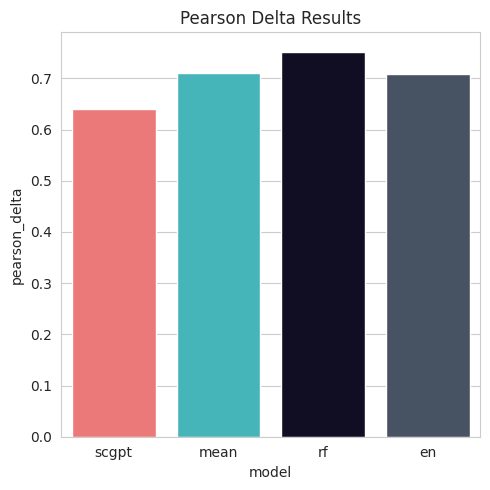

In [33]:
df = pd.DataFrame.from_dict(dict(
    scgpt=adamson_scgpt,
    mean=adamson_mean,
    rf=adamson_res,
    en=adamson_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})

plot_results(df)

In [35]:
df = pd.DataFrame.from_dict(dict(
    scgpt=norman_scpt,
    mean=norman_mean,
    rf=norman_res,
    en=norman_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})

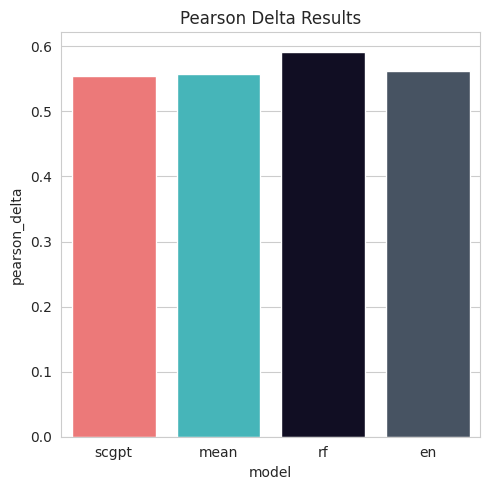

In [36]:
plot_results(df)

In [37]:
df = pd.DataFrame.from_dict(dict(
    scgpt=replogle_scgpt,
    mean=replogle_mean,
    rf=replogle_res,
    en=replogle_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})


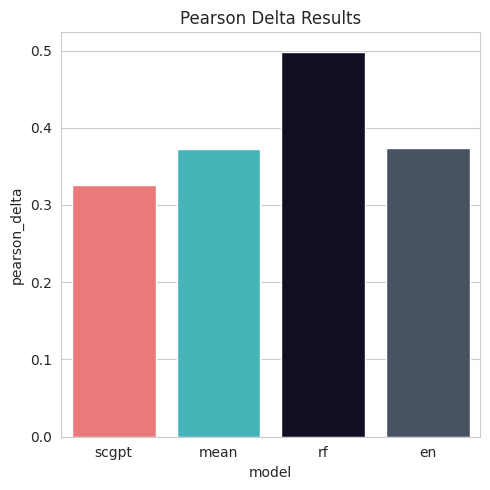

In [38]:
plot_results(df)